***Copyright 2020 The TensorFlow Authors.***

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 Tensorflow Lattice 实现道德形状约束

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/lattice/tutorials/shape_constraints_for_ethics"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看 </a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/lattice/tutorials/shape_constraints_for_ethics.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/lattice/tutorials/shape_constraints_for_ethics.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 中查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/lattice/tutorials/shape_constraints_for_ethics.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png"> 下载笔记本</a></td>
</table>

## 概述

本教程演示了如何使用 TensorFlow Lattice (TFL) 库训练对行为*负责*，并且不违反特定的*道德*或*公平*假设的模型。特别是，我们将侧重于使用单调性约束来避免对某些特性的*不公平惩罚*。本教程包括 Serena Wang 和 Maya Gupta 在 [AISTATS 2020](https://www.aistats.org/) 上发表的论文 [*Deontological Ethics By Monotonicity Shape Constraints*](https://arxiv.org/abs/2001.11990) 中的实验演示。

我们将在公共数据集上使用 TFL Canned Estimator，但请注意，本教程中的所有内容也可以使用通过 TFL Keras 层构造的模型来完成。

在继续之前，请确保您的运行时已安装所有必需的软件包（如下方代码单元中导入的软件包）。

## 设置

安装 TF Lattice 软件包：

In [2]:
#@test {"skip": true}
!pip install tensorflow-lattice seaborn

  Using cached tensorflow_lattice-2.0.9-py2.py3-none-any.whl (235 kB)


  Using cached graphviz-0.17-py3-none-any.whl (18 kB)


  Using cached dm_sonnet-2.0.0-py3-none-any.whl (254 kB)


  Using cached dm_tree-0.1.6-cp37-cp37m-manylinux_2_24_x86_64.whl (93 kB)


  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)


导入所需的软件包：

In [3]:
import tensorflow as tf

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import tensorflow_lattice as tfl
logging.disable(sys.maxsize)

本教程中使用的默认值：

In [4]:
# List of learning rate hyperparameters to try.
# For a longer list of reasonable hyperparameters, try [0.001, 0.01, 0.1].
LEARNING_RATES = [0.01]
# Default number of training epochs and batch sizes.
NUM_EPOCHS = 1000
BATCH_SIZE = 1000
# Directory containing dataset files.
DATA_DIR = 'https://raw.githubusercontent.com/serenalwang/shape_constraints_for_ethics/master'

# 案例研究 1：法学院入学

在本教程的第一部分中，我们将考虑一个使用法学院招生委员会 (LSAC) 的 Law School Admissions 数据集的案例研究。我们将训练分类器利用以下两个特征来预测学生是否会通过考试：学生的 LSAT 分数和本科生的 GPA。

假设分类器的分数用于指导法学院的招生或奖学金评定。根据基于成绩的社会规范，我们预期具有更高 GPA 和更高 LSAT 分数的学生应当从分类器中获得更高的分数。但是，我们会观察到，模型很容易违反这些直观的规范，有时会惩罚 GPA 或 LSAT 分数较高的人员。

为了解决这种*不公平的惩罚*问题，我们可以施加单调性约束，这样在其他条件相同的情况下，模型永远不会惩罚更高的 GPA 或更高的 LSAT 分数。在本教程中，我们将展示如何使用 TFL 施加这些单调性约束。

## 加载法学院数据

In [5]:
# Load data file.
law_file_name = 'lsac.csv'
law_file_path = os.path.join(DATA_DIR, law_file_name)
raw_law_df = pd.read_csv(law_file_path, delimiter=',')

预处理数据集：

In [6]:
# Define label column name.
LAW_LABEL = 'pass_bar'

In [7]:
def preprocess_law_data(input_df):
  # Drop rows with where the label or features of interest are missing.
  output_df = input_df[~input_df[LAW_LABEL].isna() & ~input_df['ugpa'].isna() &
                       (input_df['ugpa'] > 0) & ~input_df['lsat'].isna()]
  return output_df


law_df = preprocess_law_data(raw_law_df)

### 将数据划分为训练/验证/测试集

In [8]:
def split_dataset(input_df, random_state=888):
  """Splits an input dataset into train, val, and test sets."""
  train_df, test_val_df = train_test_split(
      input_df, test_size=0.3, random_state=random_state)
  val_df, test_df = train_test_split(
      test_val_df, test_size=0.66, random_state=random_state)
  return train_df, val_df, test_df


law_train_df, law_val_df, law_test_df = split_dataset(law_df)

### 可视化数据分布

首先，我们可视化数据的分布。我们将为所有通过考试的学生以及所有未通过考试的学生绘制 GPA 和 LSAT 分数。

In [9]:
def plot_dataset_contour(input_df, title):
  plt.rcParams['font.family'] = ['serif']
  g = sns.jointplot(
      x='ugpa',
      y='lsat',
      data=input_df,
      kind='kde',
      xlim=[1.4, 4],
      ylim=[0, 50])
  g.plot_joint(plt.scatter, c='b', s=10, linewidth=1, marker='+')
  g.ax_joint.collections[0].set_alpha(0)
  g.set_axis_labels('Undergraduate GPA', 'LSAT score', fontsize=14)
  g.fig.suptitle(title, fontsize=14)
  # Adust plot so that the title fits.
  plt.subplots_adjust(top=0.9)
  plt.show()

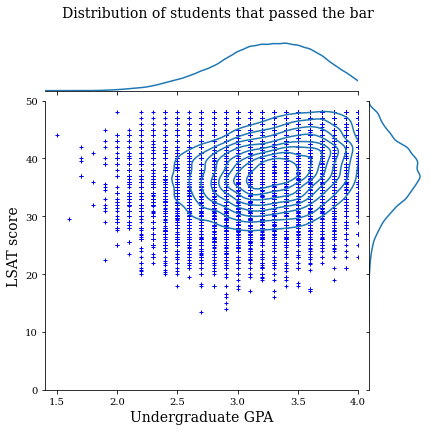

In [10]:
law_df_pos = law_df[law_df[LAW_LABEL] == 1]
plot_dataset_contour(
    law_df_pos, title='Distribution of students that passed the bar')

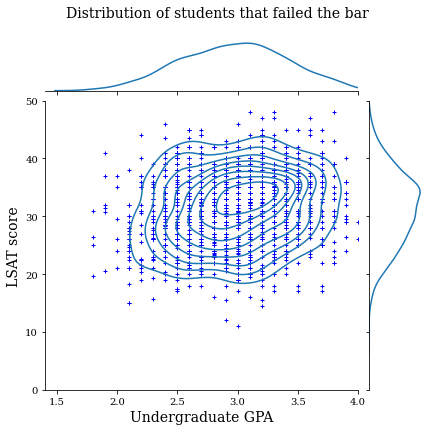

In [11]:
law_df_neg = law_df[law_df[LAW_LABEL] == 0]
plot_dataset_contour(
    law_df_neg, title='Distribution of students that failed the bar')

## 训练校准线性模型以预测考试的通过情况

接下来，我们将通过 TFL 训练*校准线性模型*，以预测学生是否会通过考试。两个输入特征分别是 LSAT 分数和本科 GPA，而训练标签将是学生是否通过了考试。

我们首先在没有任何约束的情况下训练校准线性模型。然后，我们在具有单调性约束的情况下训练校准线性模型，并观察模型输出和准确率的差异。

### 用于训练 TFL 校准线性 Estimator 的辅助函数

下面这些函数将用于此法学院案例研究以及下面的信用违约案例研究。

In [12]:
def train_tfl_estimator(train_df, monotonicity, learning_rate, num_epochs,
                        batch_size, get_input_fn,
                        get_feature_columns_and_configs):
  """Trains a TFL calibrated linear estimator.

  Args:
    train_df: pandas dataframe containing training data.
    monotonicity: if 0, then no monotonicity constraints. If 1, then all
      features are constrained to be monotonically increasing.
    learning_rate: learning rate of Adam optimizer for gradient descent.
    num_epochs: number of training epochs.
    batch_size: batch size for each epoch. None means the batch size is the full
      dataset size.
    get_input_fn: function that returns the input_fn for a TF estimator.
    get_feature_columns_and_configs: function that returns TFL feature columns
      and configs.

  Returns:
    estimator: a trained TFL calibrated linear estimator.

  """
  feature_columns, feature_configs = get_feature_columns_and_configs(
      monotonicity)

  model_config = tfl.configs.CalibratedLinearConfig(
      feature_configs=feature_configs, use_bias=False)

  estimator = tfl.estimators.CannedClassifier(
      feature_columns=feature_columns,
      model_config=model_config,
      feature_analysis_input_fn=get_input_fn(input_df=train_df, num_epochs=1),
      optimizer=tf.keras.optimizers.Adam(learning_rate))

  estimator.train(
      input_fn=get_input_fn(
          input_df=train_df, num_epochs=num_epochs, batch_size=batch_size))
  return estimator


def optimize_learning_rates(
    train_df,
    val_df,
    test_df,
    monotonicity,
    learning_rates,
    num_epochs,
    batch_size,
    get_input_fn,
    get_feature_columns_and_configs,
):
  """Optimizes learning rates for TFL estimators.

  Args:
    train_df: pandas dataframe containing training data.
    val_df: pandas dataframe containing validation data.
    test_df: pandas dataframe containing test data.
    monotonicity: if 0, then no monotonicity constraints. If 1, then all
      features are constrained to be monotonically increasing.
    learning_rates: list of learning rates to try.
    num_epochs: number of training epochs.
    batch_size: batch size for each epoch. None means the batch size is the full
      dataset size.
    get_input_fn: function that returns the input_fn for a TF estimator.
    get_feature_columns_and_configs: function that returns TFL feature columns
      and configs.

  Returns:
    A single TFL estimator that achieved the best validation accuracy.
  """
  estimators = []
  train_accuracies = []
  val_accuracies = []
  test_accuracies = []
  for lr in learning_rates:
    estimator = train_tfl_estimator(
        train_df=train_df,
        monotonicity=monotonicity,
        learning_rate=lr,
        num_epochs=num_epochs,
        batch_size=batch_size,
        get_input_fn=get_input_fn,
        get_feature_columns_and_configs=get_feature_columns_and_configs)
    estimators.append(estimator)
    train_acc = estimator.evaluate(
        input_fn=get_input_fn(train_df, num_epochs=1))['accuracy']
    val_acc = estimator.evaluate(
        input_fn=get_input_fn(val_df, num_epochs=1))['accuracy']
    test_acc = estimator.evaluate(
        input_fn=get_input_fn(test_df, num_epochs=1))['accuracy']
    print('accuracies for learning rate %f: train: %f, val: %f, test: %f' %
          (lr, train_acc, val_acc, test_acc))
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
  max_index = val_accuracies.index(max(val_accuracies))
  return estimators[max_index]

### 用于配置法学院数据集特征的辅助函数

下面这些辅助函数专用于法学院案例研究。

In [13]:
def get_input_fn_law(input_df, num_epochs, batch_size=None):
  """Gets TF input_fn for law school models."""
  return tf.compat.v1.estimator.inputs.pandas_input_fn(
      x=input_df[['ugpa', 'lsat']],
      y=input_df['pass_bar'],
      num_epochs=num_epochs,
      batch_size=batch_size or len(input_df),
      shuffle=False)


def get_feature_columns_and_configs_law(monotonicity):
  """Gets TFL feature configs for law school models."""
  feature_columns = [
      tf.feature_column.numeric_column('ugpa'),
      tf.feature_column.numeric_column('lsat'),
  ]
  feature_configs = [
      tfl.configs.FeatureConfig(
          name='ugpa',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
      tfl.configs.FeatureConfig(
          name='lsat',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
  ]
  return feature_columns, feature_configs

### 用于可视化训练的模型输出的辅助函数

In [14]:
def get_predicted_probabilities(estimator, input_df, get_input_fn):
  predictions = estimator.predict(
      input_fn=get_input_fn(input_df=input_df, num_epochs=1))
  return [prediction['probabilities'][1] for prediction in predictions]


def plot_model_contour(estimator, input_df, num_keypoints=20):
  x = np.linspace(min(input_df['ugpa']), max(input_df['ugpa']), num_keypoints)
  y = np.linspace(min(input_df['lsat']), max(input_df['lsat']), num_keypoints)

  x_grid, y_grid = np.meshgrid(x, y)

  positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
  plot_df = pd.DataFrame(positions.T, columns=['ugpa', 'lsat'])
  plot_df[LAW_LABEL] = np.ones(len(plot_df))
  predictions = get_predicted_probabilities(
      estimator=estimator, input_df=plot_df, get_input_fn=get_input_fn_law)
  grid_predictions = np.reshape(predictions, x_grid.shape)

  plt.rcParams['font.family'] = ['serif']
  plt.contour(
      x_grid,
      y_grid,
      grid_predictions,
      colors=('k',),
      levels=np.linspace(0, 1, 11))
  plt.contourf(
      x_grid,
      y_grid,
      grid_predictions,
      cmap=plt.cm.bone,
      levels=np.linspace(0, 1, 11))  # levels=np.linspace(0,1,8));
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

  cbar = plt.colorbar()
  cbar.ax.set_ylabel('Model score', fontsize=20)
  cbar.ax.tick_params(labelsize=20)

  plt.xlabel('Undergraduate GPA', fontsize=20)
  plt.ylabel('LSAT score', fontsize=20)

## 训练无约束（非单调）的校准线性模型

In [15]:
nomon_linear_estimator = optimize_learning_rates(
    train_df=law_train_df,
    val_df=law_val_df,
    test_df=law_test_df,
    monotonicity=0,
    learning_rates=LEARNING_RATES,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    get_input_fn=get_input_fn_law,
    get_feature_columns_and_configs=get_feature_columns_and_configs_law)

accuracies for learning rate 0.010000: train: 0.949061, val: 0.945876, test: 0.951781


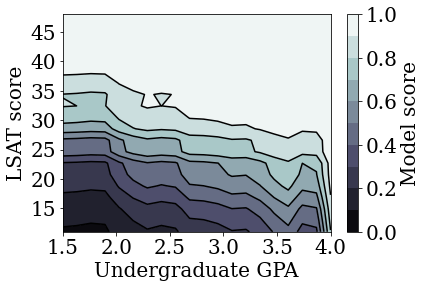

In [16]:
plot_model_contour(nomon_linear_estimator, input_df=law_df)

## 训练单调的校准线性模型

In [17]:
mon_linear_estimator = optimize_learning_rates(
    train_df=law_train_df,
    val_df=law_val_df,
    test_df=law_test_df,
    monotonicity=1,
    learning_rates=LEARNING_RATES,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    get_input_fn=get_input_fn_law,
    get_feature_columns_and_configs=get_feature_columns_and_configs_law)

accuracies for learning rate 0.010000: train: 0.949249, val: 0.945447, test: 0.951781


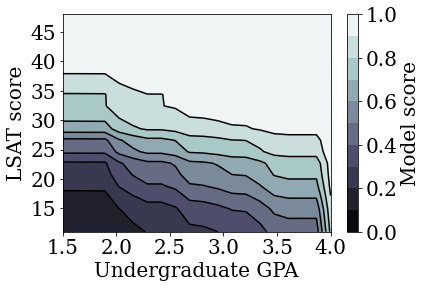

In [18]:
plot_model_contour(mon_linear_estimator, input_df=law_df)

## 训练其他无约束的模型

我们演示了可以将 TFL 校准线性模型训练成在 LSAT 分数和 GPA 上均单调，而不会牺牲过多的准确率。

但是，与其他类型的模型（如深度神经网络 (DNN) 或梯度提升树 (GBT)）相比，校准线性模型表现如何？DNN 和 GBT 看起来会有公平合理的输出吗？为了解决这一问题，我们接下来将训练无约束的 DNN 和 GBT。实际上，我们将观察到 DNN 和 GBT 都很容易违反 LSAT 分数和本科生 GPA 中的单调性。

### 训练无约束的深度神经网络 (DNN) 模型

之前已对此架构进行了优化，可以实现较高的验证准确率。

In [19]:
feature_names = ['ugpa', 'lsat']

dnn_estimator = tf.estimator.DNNClassifier(
    feature_columns=[
        tf.feature_column.numeric_column(feature) for feature in feature_names
    ],
    hidden_units=[100, 100],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.008),
    activation_fn=tf.nn.relu)

dnn_estimator.train(
    input_fn=get_input_fn_law(
        law_train_df, batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS))
dnn_train_acc = dnn_estimator.evaluate(
    input_fn=get_input_fn_law(law_train_df, num_epochs=1))['accuracy']
dnn_val_acc = dnn_estimator.evaluate(
    input_fn=get_input_fn_law(law_val_df, num_epochs=1))['accuracy']
dnn_test_acc = dnn_estimator.evaluate(
    input_fn=get_input_fn_law(law_test_df, num_epochs=1))['accuracy']
print('accuracies for DNN: train: %f, val: %f, test: %f' %
      (dnn_train_acc, dnn_val_acc, dnn_test_acc))

accuracies for DNN: train: 0.948936, val: 0.947165, test: 0.951781


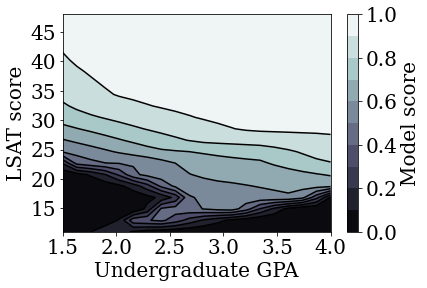

In [20]:
plot_model_contour(dnn_estimator, input_df=law_df)

### 训练无约束的梯度提升树 (GBT) 模型

之前已对此树形结构进行了优化，可以实现较高的验证准确率。

In [21]:
tree_estimator = tf.estimator.BoostedTreesClassifier(
    feature_columns=[
        tf.feature_column.numeric_column(feature) for feature in feature_names
    ],
    n_batches_per_layer=2,
    n_trees=20,
    max_depth=4)

tree_estimator.train(
    input_fn=get_input_fn_law(
        law_train_df, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE))
tree_train_acc = tree_estimator.evaluate(
    input_fn=get_input_fn_law(law_train_df, num_epochs=1))['accuracy']
tree_val_acc = tree_estimator.evaluate(
    input_fn=get_input_fn_law(law_val_df, num_epochs=1))['accuracy']
tree_test_acc = tree_estimator.evaluate(
    input_fn=get_input_fn_law(law_test_df, num_epochs=1))['accuracy']
print('accuracies for GBT: train: %f, val: %f, test: %f' %
      (tree_train_acc, tree_val_acc, tree_test_acc))

accuracies for GBT: train: 0.949312, val: 0.945876, test: 0.951117


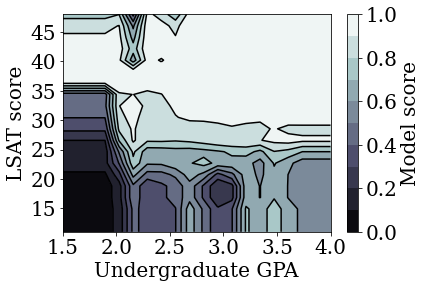

In [22]:
plot_model_contour(tree_estimator, input_df=law_df)

# 案例研究 2：信用违约

我们将在本教程中考虑的第二个案例研究是预测个人的信用违约概率。我们将使用 UCI 存储库中的 Default of Credit Card Clients 数据集。这些数据收集自 30,000 名中国台湾信用卡用户，并包含一个二元标签，用于标识用户是否在时间窗口内拖欠了付款。特征包括婚姻状况、性别、教育程度以及在 2005 年 4-9 月的每个月中，用户拖欠现有账单的时间有多长。

正如我们在第一个案例研究中所做的那样，我们再次阐明了使用单调性约束来避免*不公平的惩罚*：使用该模型来确定用户的信用评分时，在其他条件都相同的情况下，如果许多人因较早支付账单而受到惩罚，那么这对他们来说是不公平的。因此，我们应用了单调性约束，使模型不会惩罚提前付款。

## 加载信用违约数据

In [23]:
# Load data file.
credit_file_name = 'credit_default.csv'
credit_file_path = os.path.join(DATA_DIR, credit_file_name)
credit_df = pd.read_csv(credit_file_path, delimiter=',')

In [24]:
# Define label column name.
CREDIT_LABEL = 'default'

### 将数据划分为训练/验证/测试集

In [25]:
credit_train_df, credit_val_df, credit_test_df = split_dataset(credit_df)

### 可视化数据分布

首先，我们可视化数据的分布。我们将为婚姻状况和还款状况不同的人绘制观察到的违约率的平均值和标准误差。还款状态表示一个人已偿还贷款的月数（截至 2005 年 4 月）。

In [26]:
def get_agg_data(df, x_col, y_col, bins=11):
  xbins = pd.cut(df[x_col], bins=bins)
  data = df[[x_col, y_col]].groupby(xbins).agg(['mean', 'sem'])
  return data


def plot_2d_means_credit(input_df, x_col, y_col, x_label, y_label):
  plt.rcParams['font.family'] = ['serif']
  _, ax = plt.subplots(nrows=1, ncols=1)
  plt.setp(ax.spines.values(), color='black', linewidth=1)
  ax.tick_params(
      direction='in', length=6, width=1, top=False, right=False, labelsize=18)
  df_single = get_agg_data(input_df[input_df['MARRIAGE'] == 1], x_col, y_col)
  df_married = get_agg_data(input_df[input_df['MARRIAGE'] == 2], x_col, y_col)
  ax.errorbar(
      df_single[(x_col, 'mean')],
      df_single[(y_col, 'mean')],
      xerr=df_single[(x_col, 'sem')],
      yerr=df_single[(y_col, 'sem')],
      color='orange',
      marker='s',
      capsize=3,
      capthick=1,
      label='Single',
      markersize=10,
      linestyle='')
  ax.errorbar(
      df_married[(x_col, 'mean')],
      df_married[(y_col, 'mean')],
      xerr=df_married[(x_col, 'sem')],
      yerr=df_married[(y_col, 'sem')],
      color='b',
      marker='^',
      capsize=3,
      capthick=1,
      label='Married',
      markersize=10,
      linestyle='')
  leg = ax.legend(loc='upper left', fontsize=18, frameon=True, numpoints=1)
  ax.set_xlabel(x_label, fontsize=18)
  ax.set_ylabel(y_label, fontsize=18)
  ax.set_ylim(0, 1.1)
  ax.set_xlim(-2, 8.5)
  ax.patch.set_facecolor('white')
  leg.get_frame().set_edgecolor('black')
  leg.get_frame().set_facecolor('white')
  leg.get_frame().set_linewidth(1)
  plt.show()

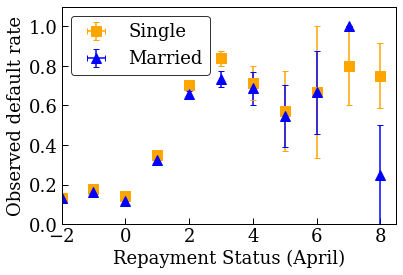

In [27]:
plot_2d_means_credit(credit_train_df, 'PAY_0', 'default',
                     'Repayment Status (April)', 'Observed default rate')

## 训练校准线性模型以预测信用违约率

接下来，我们将通过 TFL 训练*校准线性模型*，以预测某人是否会拖欠贷款。两个输入特征将是该人的婚姻状况以及该人截至 4 月已偿还贷款的月数（还款状态）。训练标签将是该人是否拖欠过贷款。

我们首先在没有任何约束的情况下训练校准线性模型。然后，我们在具有单调性约束的情况下训练校准线性模型，并观察模型输出和准确率的差异。

### 用于配置信用违约数据集特征的辅助函数

下面这些辅助函数专用于信用违约案例研究。

In [28]:
def get_input_fn_credit(input_df, num_epochs, batch_size=None):
  """Gets TF input_fn for credit default models."""
  return tf.compat.v1.estimator.inputs.pandas_input_fn(
      x=input_df[['MARRIAGE', 'PAY_0']],
      y=input_df['default'],
      num_epochs=num_epochs,
      batch_size=batch_size or len(input_df),
      shuffle=False)


def get_feature_columns_and_configs_credit(monotonicity):
  """Gets TFL feature configs for credit default models."""
  feature_columns = [
      tf.feature_column.numeric_column('MARRIAGE'),
      tf.feature_column.numeric_column('PAY_0'),
  ]
  feature_configs = [
      tfl.configs.FeatureConfig(
          name='MARRIAGE',
          lattice_size=2,
          pwl_calibration_num_keypoints=3,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
      tfl.configs.FeatureConfig(
          name='PAY_0',
          lattice_size=2,
          pwl_calibration_num_keypoints=10,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
  ]
  return feature_columns, feature_configs

### 用于可视化训练的模型输出的辅助函数

In [29]:
def plot_predictions_credit(input_df,
                            estimator,
                            x_col,
                            x_label='Repayment Status (April)',
                            y_label='Predicted default probability'):
  predictions = get_predicted_probabilities(
      estimator=estimator, input_df=input_df, get_input_fn=get_input_fn_credit)
  new_df = input_df.copy()
  new_df.loc[:, 'predictions'] = predictions
  plot_2d_means_credit(new_df, x_col, 'predictions', x_label, y_label)

## 训练无约束（非单调）的校准线性模型

In [30]:
nomon_linear_estimator = optimize_learning_rates(
    train_df=credit_train_df,
    val_df=credit_val_df,
    test_df=credit_test_df,
    monotonicity=0,
    learning_rates=LEARNING_RATES,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    get_input_fn=get_input_fn_credit,
    get_feature_columns_and_configs=get_feature_columns_and_configs_credit)

accuracies for learning rate 0.010000: train: 0.818762, val: 0.830065, test: 0.817172


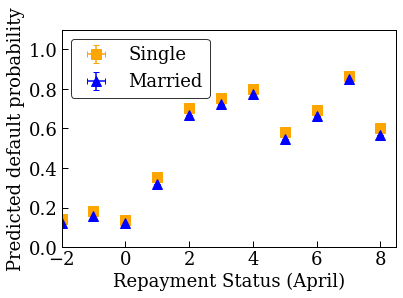

In [31]:
plot_predictions_credit(credit_train_df, nomon_linear_estimator, 'PAY_0')

## 训练单调的校准线性模型

In [32]:
mon_linear_estimator = optimize_learning_rates(
    train_df=credit_train_df,
    val_df=credit_val_df,
    test_df=credit_test_df,
    monotonicity=1,
    learning_rates=LEARNING_RATES,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    get_input_fn=get_input_fn_credit,
    get_feature_columns_and_configs=get_feature_columns_and_configs_credit)

accuracies for learning rate 0.010000: train: 0.818762, val: 0.830065, test: 0.817172


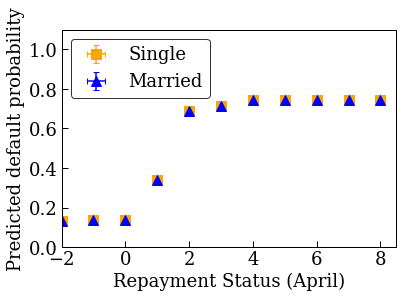

In [33]:
plot_predictions_credit(credit_train_df, mon_linear_estimator, 'PAY_0')